In [3]:
import os
import numpy as np
import mne
import imageio
import h5py
#import scipy.fftpack
import matplotlib
%matplotlib inline
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
#import scipy.io as sio
#from scipy.integrate import simps
import pandas as pd
#from scipy import fft
import matplotlib.mlab as mlab
import sys
sys.path.append('./py_functions')
import analys_func
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath
root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
sys.path.append('./PCI/')
sys.path.append('./PCI/PCIst')
import pci_st as pci
import basic_func as bf
from matplotlib.patches import Rectangle
import tqdm
import similarity_funcs as sf

import freq_funcs as ff
subj            = "EL010"
cwd             = os.getcwd()


if platform.system()=='Windows':
    sep = ','
    path_patient = 'T:\EL_experiment\Patients\\'+subj
    #path_patient    = 'E:\PhD\EL_experiment\Patients\\'+subj # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
else: #'Darwin' for MAC
    path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subj
    sep =';'
sep =';'    

color_elab      = ['#594157', "#F1BF98","#8FB996"]
t_label         = ['Baseline', 'Flumazenil', 'Benzodiazepin']  # ['Baseline', 'Flumazenil', 'Benzodiazepin']
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all      = lbls.label.values
labels_clinic   = lbls.Clinic.values
labels_region   = lbls.Region.values
labels_L        = lbls.Hemisphere.values
nodes           = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
#if subj == 'EL006':
 #     labels_all      = lbls.Clinic.values

bad_stims = np.where(labels_region=='OUT')[0]

##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]
regions = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\elab_labels.xlsx", sheet_name='regions', header=0)
color_regions = regions.color.values
C =regions.label.values

In [4]:
regions       = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\elab_labels.xlsx", sheet_name='regions', header=0)
color_regions = regions.color.values
regions_G = regions.subregion.values
regions =regions.label.values

In [18]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((3,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])

In [19]:
## load
EEG_resp = np.load(path_patient + '/Analysis/BrainMapping/data/All_resps.npy')
stimlist = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/Stimlist.csv')
print('data loaded with '+str(EEG_resp.shape[1])+' stimulations')
print(EEG_resp.shape)
badchans = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])
if len(stimlist)!= EEG_resp.shape[1]:
    print("WARNING: number of stimulations don't agree!")

data loaded with 2139 stimulations
(63, 2139, 2000)


In [20]:
hours = np.unique(stimlist.h)
# get stimulation channels directly from stimlist
StimChanSM   = np.unique(stimlist.ChanP)
ChanN        = np.zeros((len(StimChanSM),))
StimChans    = []#np.zeros((len(stim_chan)))
StimChansC   = []#np.zeros((len(stim_chan)))
StimChanIx   = []#np.zeros((len(stim_chan)))
for i in range(len(StimChanSM)):
    ChanN[i] =  np.median(stimlist[stimlist.ChanP==StimChanSM[i]].ChanN)
    #StimChans.append(labels_SM[(np.array(labels.chan_num.values)==stim_chan[i,0])][0])
    StimChans.append(labels_all[(np.array(lbls.ChanP_SM.values)==StimChanSM[i])&(np.array(lbls.ChanN_SM.values)==ChanN[i])][0])
    StimChansC.append(labels_clinic[(np.array(lbls.ChanP_SM.values)==StimChanSM[i])&(np.array(lbls.ChanN_SM.values)==ChanN[i])][0])
    StimChanIx.append(lbls[(np.array(lbls.ChanP_SM.values)==StimChanSM[i])&(np.array(lbls.ChanN_SM.values)==ChanN[i])]['Num'].values[0]-1)
    # bad channels
labels_sort     = labels_all[np.argsort(labels_region)]

In [25]:

v               = np.sort(labels_region)
region_border   = np.where(np.roll(v,1)!=v)[0]
region_border   = np.concatenate([region_border, [len(labels_all)]])
region_num      = np.diff(region_border)
labels_sort     = labels_all[np.argsort(labels_region)]
labels_region_sort = np.sort(labels_region)
StimChanIx_sort = np.argsort(labels_region)

In [22]:
CR_color = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24,3))
CR_color[6:18,:] =np.array([253, 184, 19 ])/255

In [23]:
LL_CCEP_file = path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_CR.csv'
if os.path.isfile(LL_CCEP_file):
    LL_CCEP    = pd.read_csv(LL_CCEP_file)
else:
    LL_CCEP    = bf.LL_BM_cond(EEG_resp, stimlist, 'h', bad_chans, coord_all, labels_clinic,StimChanSM,StimChanIx )
LL_CCEP.to_csv(LL_CCEP_file, index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
chan_thr_file = path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr.csv'
if os.path.isfile(LL_CCEP_file):
    chan_thr    = pd.read_csv(chan_thr_file).values
else:
    chan_thr  = bf.get_LL_thr(EEG_resp, LL_CCEP, labels_all, path_patient)

In [8]:
stop

NameError: name 'stop' is not defined

In [5]:
ix = np.argsort(regions_G)

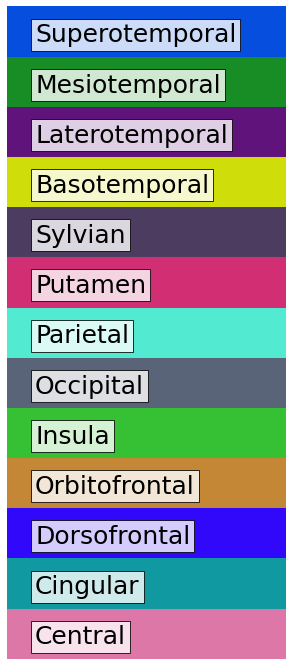

In [7]:
fig, ax     = plt.subplots(figsize=(5,12))
for i in range(len(regions)):
    ax.add_patch(Rectangle((0,i), 5, 1, alpha=1, facecolor= color_regions[ix[i]]))
    t = plt.text(0.1, i+0.3, regions[ix[i]], fontsize=25)
    t.set_bbox(dict(facecolor='white', alpha=0.8))
    #plt.text(0.2, i+0.2, regions[ix[i]])
plt.ylim(0,len(regions))
plt.axis('off')
plt.savefig('T:\EL_experiment\\Patients\\all\\regions.svg')
plt.show()

In [ ]:
cond_sel ='CR'
cond_val = np.arange(1,24)
cond_labels
for c in cond_val:
    LL_CCEP, M_resp = bf.get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all, chan_thr, c,'Hour', 500 )

    ## delete WM
    labels_sel   = np.delete(labels_all, (labels_region =='OUT')|(labels_region =='WM'), 0)
    areas_sel    = np.delete(labels_region, (labels_region =='OUT')|(labels_region =='WM'), 0)
    lat_sel = np.delete(lbls.Hemisphere.values,(labels_region =='OUT')|(labels_region =='WM'), 0)

    M = M_resp[:,:,2]
    M = np.delete(M, (labels_region =='OUT')|(labels_region =='WM'), 0)
    M = np.delete(M, (labels_region =='OUT')|(labels_region =='WM'), 1)
    ## sort
    ind = np.lexsort((areas_sel,lat_sel))
    M = M[ind,:]
    M = M[:,ind]
    labels_sel = labels_sel[ind]
    areas_sel = areas_sel[ind]
    # sort

    plot_BM_CR(M, labels_sel, areas_sel, c)
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_CR.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')

  2%|██▊                                                                                                                                                                            | 1/63 [00:01<01:31,  1.47s/it]

In [15]:
if not ('RespC' in LL_CCEP.columns):
    cond_sel ='CR'
    cond_val = np.arange(1,24)
    cond_labels
    for c in cond_val:
        LL_CCEP, M_resp = bf.get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all, chan_thr, c,'Hour', 500 )

        ## delete WM
        labels_sel   = np.delete(labels_all, (labels_region =='OUT')|(labels_region =='WM'), 0)
        areas_sel    = np.delete(labels_region, (labels_region =='OUT')|(labels_region =='WM'), 0)
        lat_sel = np.delete(lbls.Hemisphere.values,(labels_region =='OUT')|(labels_region =='WM'), 0)

        M = M_resp[:,:,2]
        M = np.delete(M, (labels_region =='OUT')|(labels_region =='WM'), 0)
        M = np.delete(M, (labels_region =='OUT')|(labels_region =='WM'), 1)
        ## sort
        ind = np.lexsort((areas_sel,lat_sel))
        M = M[ind,:]
        M = M[:,ind]
        labels_sel = labels_sel[ind]
        areas_sel = areas_sel[ind]
        # sort

        plot_BM_CR(M, labels_sel, areas_sel, c)
    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_CR.csv', index=False,
                  header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
LL_CCEP    = bf.LL_BM_cond(EEG_resp, stimlist[stimlist.condition==0], 'h', bad_chans, coord_all, labels_clinic,StimChanSM,StimChanIx )
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_CR.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
chan_thr  = bf.get_LL_thr(EEG_resp, LL_CCEP, labels_all, path_patient)

In [ ]:
#chan_thr = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr.csv').values

LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/connection.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [14]:
def plot_BM_CR(M, labels,areas, c):
    t = str(c)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=0, vmax= 20)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[c], alpha = CR_color_a[c])
    plt.text(0.3,0.3, t)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+str(c)+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+str(c)+'.jpg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/GIF/BM_'+str(c)+'.jpg')

In [ ]:
cond_sel ='CR'
cond_val = np.arange(1,24)
cond_labels
for c in cond_val:
    LL_CCEP, M_resp = bf.get_SigCon_BM_cond(LL_CCEP, EEG_resp, labels_all, chan_thr, c,'Hour', 500 )
    
    ## delete WM
    labels_sel   = np.delete(labels_all, (labels_region =='OUT')|(labels_region =='WM'), 0)
    areas_sel    = np.delete(labels_region, (labels_region =='OUT')|(labels_region =='WM'), 0)
    lat_sel = np.delete(lbls.Hemisphere.values,(labels_region =='OUT')|(labels_region =='WM'), 0)

    M = M_resp[:,:,2]
    M = np.delete(M, (labels_region =='OUT')|(labels_region =='WM'), 0)
    M = np.delete(M, (labels_region =='OUT')|(labels_region =='WM'), 1)
    ## sort
    ind = np.lexsort((areas_sel,lat_sel))
    M = M[ind,:]
    M = M[:,ind]
    labels_sel = labels_sel[ind]
    areas_sel = areas_sel[ind]
    # sort

    plot_BM(M, labels_sel, areas_sel, c)
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_CR.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
plot_BM(M, labels_sel, areas_sel, c)

In [ ]:
stop

In [ ]:
plot_conds(23, 73, LL_CCEP, [0,1,3], EEG_resp, 1)

## summarize each patient

In [ ]:
data_asym     = np.zeros((1,8))
lists         = LL_CCEP[(LL_CCEP.RespC>-1)&(LL_CCEP.Condition>0)] # only Ph protocol
lists         = lists[~np.isnan(lists.LL.values)]
stims         = np.unique(lists.Stim).astype('int')
for sc in stims:
    resps = np.unique(lists.loc[(lists.Stim==sc), 'Chan']).astype('int')
    for rc in resps:
        list_1      = lists[(lists.Chan==rc)&(lists.Stim==sc)]
        # general data
        val         = np.zeros((1, 8))
        val[0, 0]   = rc                                         # response channel
        val[0, 1]   = sc                                         # response channel
        val[0, 2]   = np.nanmean(list_1.d)
        # 
        if np.mean(list_1.loc[(list_1.Condition==1), 'RespC'])==1:
            val[0, 3]   = np.mean(list_1.loc[(list_1.Condition==1), 'LLpeak'])
            d = bf.get_cluster_pred(sc, rc, LL_CCEP,EEG_resp)
            # LL cluster
            val[0, 5]   = d[0]#np.nanmean(list_1.Benzo)
            val[0, 6]   = d[1]#np.nanmean(list_1.Benzo)
            val[0, 7]   = bf.get_mean_BL_B(sc, rc, LL_CCEP, conds=[1,3], w=0.25)
        if np.mean(list_1.loc[(list_1.Condition==3), 'RespC'])==1:
            val[0, 4]   = np.mean(list_1.loc[(list_1.Condition==3), 'LLpeak'])    
            
        data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"RespC": data_asym[:, 0], "StimC": data_asym[:, 1], "d": data_asym[:, 2], "LL_BL": data_asym[:, 3], "LL_BZD": data_asym[:, 4], "Cluster_BL": data_asym[:, 5], "Cluster_BZD": data_asym[:, 6], "invBZD": data_asym[:, 7]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.RespC ==c), "RespR"]   = labels_region[c]
    data_A.loc[(data_A.RespC ==c), "Resp"]   = labels_all[c]
    data_A.loc[(data_A.StimC ==c), "StimR"]   = labels_region[c]
    data_A.loc[(data_A.StimC ==c), "Stim"]  = labels_all[c]


data_A=data_A.drop(data_A[data_A['StimR']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['RespR']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['StimR']=='WM'].index)
data_A=data_A.drop(data_A[data_A['RespR']=='WM'].index)

data_A.insert(5, 'LL_Ratio',0)
data_A.LL_Ratio = data_A.LL_BZD/data_A.LL_BL

data_A.to_csv(path_patient + '/Analysis/BrainMapping/LL/connection_CR.csv', index=False,
              header=True)

In [ ]:
dat = data_A[(data_A.LL_BL>0)&(data_A.LL_Ratio<1)]
k        = np.random.randint(0, len(dat))
sc       = np.int64(dat.StimC.values[k])
rc       = np.int64(dat.RespC.values[k])
plot_conds(sc, rc, LL_CCEP, [1,3], EEG_resp, 0)

In [ ]:
plot_conds(sc, rc, LL_CCEP, [1,3], EEG_resp, 1)

In [ ]:
LL_CCEP

In [ ]:
def plot_conds(sc, rc, LL_CCEP, conds, EEG_resp, save):
    ylim = 200
    fig, axs   = plt.subplots(len(conds),1, figsize=(6,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_all[sc]+'--'+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')[0:3]
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', mean LL: '+str(np.round(np.mean(lists.LLpeak.values),1))+'uV/ms')
        #axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.5, 1.5)
        axs[i].set_xticks([])
        
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            #axs[i].plot(x_ax,EEG_resp[rc,stimNum_all[j],:], c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 20, Fs), c=[0,0,0], linewidth=3 )
        ylim = np.max([ylim,np.max(abs(ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,500:1500],0), 45, Fs))) ])
    ylim = 1.2*np.min([600, ylim])
    for i in range(len(conds)):
        axs[i].set_ylim(-ylim, ylim)
    
    plt.xticks([-0.5, 0, 0.5,1, 1.5])
    plt.xlabel('time [s]')
    if save:
        filename    = 'T:\EL_experiment\Patients\\all\\Analysis\BrainMapping\BZD_trial\\'+subj+'_'+ labels_all[sc]+'-'+labels_all[rc]+ '.png'
        plt.savefig(filename)
        filename    = 'T:\EL_experiment\Patients\\all\\Analysis\BrainMapping\BZD_trial\\'+subj+'_'+ labels_all[sc]+'-'+labels_all[rc]+ '.svg'
        plt.savefig(filename)
    plt.show()

In [ ]:
data_asym     = np.zeros((1,8))
lists         = LL_CCEP[(LL_CCEP.RespC>-1)&(LL_CCEP.Condition>0)] # only Ph protocol
lists         = lists[~np.isnan(lists.LL.values)]
stims         = np.unique(lists.Stim).astype('int')
for sc in stims:
    resps = np.unique(lists.loc[(lists.Stim==sc), 'Chan']).astype('int')
    for rc in resps:
        list_1      = lists[(lists.Chan==rc)&(lists.Stim==sc)]
        # general data
        val         = np.zeros((1, 8))
        val[0, 0]   = rc                                         # response channel
        val[0, 1]   = sc                                         # response channel
        val[0, 2]   = np.nanmean(list_1.d)
        # 
        if np.mean(list_1.loc[(list_1.Condition==1), 'RespC'])==1:
            val[0, 3]   = np.mean(list_1.loc[(list_1.Condition==1), 'LLpeak'])
            d = get_cluster_pred(sc, rc, LL_CCEP,EEG_resp)
            # LL cluster
            val[0, 5]   = d[0]#np.nanmean(list_1.Benzo)
            val[0, 6]   = d[1]#np.nanmean(list_1.Benzo)
            val[0, 7]   = get_mean_BL_B(sc, rc, LL_CCEP, conds=[1,3], w=0.25)
        if np.mean(list_1.loc[(list_1.Condition==3), 'RespC'])==1:
            val[0, 4]   = np.mean(list_1.loc[(list_1.Condition==3), 'LLpeak'])    
            
        data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"RespC": data_asym[:, 0], "StimC": data_asym[:, 1], "d": data_asym[:, 2], "LL_BL": data_asym[:, 3], "LL_BZD": data_asym[:, 4], "Cluster_BL": data_asym[:, 5], "Cluster_BZD": data_asym[:, 6], "invBZD": data_asym[:, 7]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.RespC ==c), "RespR"]   = labels_region[c]
    data_A.loc[(data_A.RespC ==c), "Resp"]   = labels_all[c]
    data_A.loc[(data_A.StimC ==c), "StimR"]   = labels_region[c]
    data_A.loc[(data_A.StimC ==c), "Stim"]  = labels_all[c]


data_A=data_A.drop(data_A[data_A['StimR']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['RespR']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['StimR']=='WM'].index)
data_A=data_A.drop(data_A[data_A['RespR']=='WM'].index)

data_A.insert(5, 'LL_Ratio',0)
data_A.LL_Ratio = data_A.LL_BZD/data_A.LL_BL

data_A.to_csv(path_patient + '/Analysis/BrainMapping/LL/connection.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from scipy.spatial import distance
import itertools
def dba_cluster(X, n=2):
    km_dba      = TimeSeriesKMeans(n_clusters=n, metric="dtw", max_iter=10, max_iter_barycenter=10, random_state=0).fit(X)
    cc          = km_dba.cluster_centers_
    y           = km_dba.predict(X)
    dist = km_dba.transform(X)
    return cc, y, dist
def get_cluster_pred(sc, rc, LL_CCEP,EEG_resp):
    lists         = LL_CCEP[~np.isnan(LL_CCEP.zLL.values)&(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']>0)]
    conds_trials  = lists.Condition.values.astype('int')
    stimNum_all   = lists.Num.values.astype('int')
    d             = 0.5
    trials        = EEG_resp[rc,stimNum_all,:]
    trials_z      = scipy.stats.zscore(trials,1)
    data          = trials_z[:,np.int64(1*Fs):np.int64((1+d)*Fs)]
    pred_loss = np.zeros((2,))-1
    if data.shape[0]>0:
        cc, y_pred, dist   = dba_cluster(np.expand_dims(data,-1))
        D = dist/np.max(dist)

        
        i=0
        for cond in np.unique(conds_trials):
            d=0
            for x,y in itertools.combinations(y_pred[conds_trials==cond], 2):
                d += np.square(x-y)
            pred_loss[i]= d #np.sqrt(d)
            i=1+i
        
    return pred_loss
def get_mean_BL_B(sc, rc, LL_CCEP, conds=[1,3], w=0.25):
    rc = np.int64(rc)
    sc = np.int64(sc)
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]
    sig       = 1
    k         = 1
    n         = 3
    EEG = np.zeros((1,2000))
    for i in range(len(conds)):
        cs        = conds[i]
        list_cond = lists[lists.Condition==cs]
        stimNum                  = list_cond.Num.values.astype('int')
        if len(stimNum)<n:
            n = len(stimNum)
        if cs==3:
            k = -1
        EEG = np.concatenate([EEG, k*EEG_resp[rc,stimNum[0:n],:]])
    EEG = EEG[1:,:]
    resp       = np.nanmean(EEG[:,:],0)
    LL_resp    = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp    = LL_resp[0,0]
    thr        = np.percentile(LL_resp[0:np.int64((1-w)*Fs)],99)
    # if  all(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+w)*Fs)]>thr):
    #     sig = 2
    if  np.max(LL_resp[np.int64((1.01+w/2)*Fs):np.int64((1.01+w)*Fs)])>thr:
        sig = 2
    return sig

In [ ]:
def plot_trial(sc, rc, LL_CCEP,EEG_resp):
    t_0 = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]

    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(subj+'--'+ labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,1])
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))

    plt.legend()
    plt.show()

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
stims         = np.unique(lists.Stim)
for sc in stims:
    resps = np.unique(lists.loc[(lists.Stim==sc), 'Chan'])
    for rc in resps:
        list_1 = lists[(lists.Chan==rc)&(lists.Stim==sc)]
        val         = np.zeros((1, 6))
        val[0, 0]   = rc                                         # response channel
        val[0, 1]   = sc                                         # response channel
        val[0, 2]   = np.mean(list_1.loc[list_1.Condition==1, 'LL'])/np.mean(list_1.loc[list_1.Condition==3, 'LL'])
        val[0, 3]   = np.nanmean(list_1.Benzo)
        val[0, 4]   = np.nanmean(list_1.d)
        data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "Benzo": data_asym[:, 3], "Ratio": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A.loc[(data_A.Benzo==2)&(data_A.Ratio<1), 'Change'] = 1 # BZD increases LL
data_A.loc[(data_A.Benzo==2)&(data_A.Ratio>1), 'Change'] = -1 #BZD decreases LL

data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)



In [ ]:
#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connections by distance and regions')
k=0
xlim = 35
data_test = data_A[(data_A.Benzo==1)&(data_A.d>7.5)] ##all significant connections
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, marker = '+',c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.5, edgecolors=[0,0,0])


        
data_test = data_A[(data_A.Ratio<1)&(data_A.Benzo==2)&(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, marker = 'o',c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
        
data_test = data_A[(data_A.Ratio>1)&(data_A.Benzo==2)&(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        scatter = plt.scatter(data_plot.d.values[j], i, s=80, marker = 'd',c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-xlim/10, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))

plt.plot(-100, -100, marker = '+',c=[0,0,0], label ='no effect')
plt.plot(-100, -100, marker = 'o',c=[0,0,0], label ='increase')
plt.plot(-100, -100, marker = 'd',c=[0,0,0], label ='decrease')
plt.legend()
plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, xlim])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')

plt.show()

## PCIst

https://github.com/renzocom/PCIst

In [ ]:
par      = {'baseline_window':(-0.5, -0.02), 'response_window':(0.02,0.5), 'k':1.2, 'min_snr':1.1, 'max_var':99, 'embed':False,'n_steps':5} #
conds     = np.unique(LL_CCEP.Condition)
M_PCI    = np.zeros((len(np.unique(LL_CCEP.Stim)), len(conds)))
resp_all = np.zeros((len(np.unique(LL_CCEP.Stim)), len(labels_all),len(conds), 2000))
for i in range(len(conds)):
    cond = conds[i]
    for j in range(len(np.unique(LL_CCEP.Stim))):
        sc      = np.int64(np.sort(np.unique(LL_CCEP.Stim))[j])
        
        lists     = LL_CCEP[(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==cond)]
        if len(lists)>0:
            list_nan  = lists[np.isnan(lists.LL.values)]
            stimNum   = np.int64(np.unique(lists.Num))
            resp      = ff.lp_filter(EEG_resp[:,stimNum,:],40,Fs)
            # remove bad combinations
            for k in range(len(list_nan)):
                n = np.int64(list_nan.Num.values[k])
                n = np.where(stimNum== n)[0][0]
                resp[np.int64(list_nan.Chan.values[k]),n,:] = np.nan
            if len(resp)>0:
                mean_resp          = np.nanmean(resp, 1)
                resp_all[j,:,i,:]  = mean_resp
                if np.nanmean(abs(mean_resp))>0: 
                    PCIst              =  pci.calc_PCIst(np.nan_to_num(mean_resp), np.arange(-1,3, 1/Fs), **par)
                    M_PCI[j,i]         = PCIst
                else:# if all data are nan
                    M_PCI[j,i]         = -1
        else:
                M_PCI[j,i]         = -1
                resp_all[j,:,i,:]  = np.nan
                
labels_stims = labels_all[np.int64(np.sort(np.unique(LL_CCEP.Stim)))]

In [ ]:
np.save(path_patient + '/Analysis/BrainMapping/PCI/PCI_h.npy', M_PCI)

In [ ]:
try:
    os.mkdir(path_patient + '/Analysis/BrainMapping/PCI/figures/')
    os.mkdir( path_patient + '/Analysis/BrainMapping/PCI/')
    
except OSError:
    print("test already exists")
filename     = path_patient + '/Analysis/BrainMapping/PCI/figures/PCI_hours.png'


In [ ]:
cond_label = ['BM', 'BL', 'Benzo']

In [ ]:
LL_CCEP[(LL_CCEP.Chan==65)&(LL_CCEP.Stim==61)]

In [ ]:
sc = 55
fig, axs = plt.subplots(3,1, figsize=(8,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.1)
plt.suptitle(labels_stims[sc])
axs = axs.ravel()
for i in range(3):
    axs[i].set_title(cond_label[i]+', PCI: '+str(np.round(M_PCI[sc,i])))
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylim(-700, 700)
    axs[i].set_xlim(-0.5, 1)
    axs[i].axvline(0, c=[0,0,0])
    for c in range(len(labels_all)):
        axs[i].plot(x_ax,resp_all[sc,c,i,:] )
plt.xticks([-0.5, 0, 0.5])
plt.xlabel('time [s]')
plt.tight_layout()

In [ ]:
filename     = path_patient + '/Analysis/BrainMapping/PCI/figures/PCI_hours.png'

# Plot distance matrix.
#cmap     = ListedColormap(['r', 'k', 'w'])
fig      = pylab.figure(figsize=(15,15))
axmatrix = fig.add_axes([0.15,0.05,0.7,0.9])#fig.add_axes([0.4,0.1,0.6,0.6])

im = axmatrix.matshow(M_PCI, aspect='auto', origin='lower',cmap='hot', vmin=np.percentile(M_PCI,10), vmax=np.percentile(M_PCI,95))

plt.xticks(np.arange(3), cond_label);
plt.xlabel('Condition')
plt.yticks(range(len(StimChans)), labels_stims);
#plt.axvline(15, c=[0,0,0], linewidth=35)
# Plot colorbar.
axcolor = fig.add_axes([0.9,0.05,0.01,0.9])
pylab.colorbar(im, cax=axcolor)
plt.savefig(filename)


## CCEP CR

In [ ]:
LL_CCEP = pd.read_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv')

In [ ]:
hours    = np.unique(LL_CCEP.Hour)
StimChanNums = np.sort(StimChanIx)
M_hour   = np.zeros((len(labels_all), len(labels_all), 3))
M_resp   = np.zeros((len(labels_all), len(labels_all)))

for sc in range(len(StimChans)):
    s  = StimChanNums[sc]
    dat = LL_CCEP.loc[(LL_CCEP.Stim ==s)]
    if len(dat)>0:
        for c in range(len(labels_all)):
            z_mean       = np.nanmean(dat.loc[(dat.Chan ==c), 'RespC'].values)
            M_resp[s,c] = z_mean
            if s == c:
                M_resp[s,c] = -1
            if z_mean ==1:
                for hs in range(3):
                    M_hour[s,c,hs] = np.nanmean(dat.loc[(dat.Condition ==conds[hs])&(dat.Chan ==c), 'LL'].values)
            
M_hour=np.nan_to_num(M_hour, -2)
M_hour[:,bad_chans,:] = -2
M_resp[:,bad_chans] = 0


In [ ]:
# Plot distance matrix.
cmap     = ListedColormap(['r', 'k', 'w'])
fig      = pylab.figure(figsize=(20,20))
axmatrix = fig.add_axes([0.15,0.15,0.9,0.9])

im = axmatrix.matshow(M_resp, aspect='auto', origin='lower',cmap= cmap)

plt.xticks(range(len(labels_all)), labels_all, rotation=90);
plt.yticks(range(len(labels_all)), labels_all);

plt.show()

In [ ]:
##test single plot
h        = 0
fig      = pylab.figure(figsize=(20,20))
axmatrix = fig.add_axes([0.1,0.1,0.9,0.9])

im = axmatrix.matshow(M_hour[:,:,h], aspect='auto', origin='lower', cmap='hot', vmin=1, vmax=10)

plt.xticks(range(len(labels_all)), labels_all, rotation=90)
plt.yticks(range(len(labels_all)), labels_all)
plt.xlabel(str(h)+':00', fontsize=16)
plt.show()

In [ ]:
plot_LL_dist(LL_CCEP, [1,3])

In [ ]:
## GIF BM
path_fig  = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot'
n_frames   = len(conds)
if not os.path.exists(path_fig):
    os.makedirs(path_fig)
    
print('Creating charts\n')
filenames = []
for i in np.arange(n_frames):
    fig      = pylab.figure(figsize=(20,20))
    axmatrix = fig.add_axes([0.1,0.1,0.8,0.8])

    im = axmatrix.matshow(M_hour[:,:,i], aspect='auto', origin='lower', cmap='hot', vmin=0.5, vmax=10)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(labels_all)), labels_all)
    plt.xlabel(cond_label[i], fontsize=16)
    # build file name and append to list of file names
    filename = path_fig+'/frame_'+str(i)+'.png'
    filenames.append(filename)

    # save img
    plt.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(path_fig+'/scatter.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
 # Remove files
#for filename in set(filenames):
#    os.remove(filename)
print('DONE')

## Asymmetry

In [ ]:
stim_av = StimChanIx
for i in range(len(bad_chans)):
    stim_av = np.delete(stim_av, np.where(stim_av==bad_chans[i]))

In [ ]:
##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'Benzo']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)]
        if len(list_1)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "Diff": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)

#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connections by distance and regions')
k=0

data_test = data_A[(data_A.d>7.5)] 
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-15, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))


plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, 105])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')
plt.show()

In [ ]:
c1 = np.random.choice(stim_av)
c2 = np.random.choice(stim_av)

conds = [0]#[1,3]
fig   = plt.figure(figsize=(12, len(conds)*6))
gs    = fig.add_gridspec(len(conds),2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle(labels_all[c1]+'<-->'+labels_all[c2]+', Dist: '+str(np.round(np.mean(lists.d),1))+'mm')

for i in range(len(conds)):
    ##plot 1
    ax         = fig.add_subplot(gs[i,0])  
    lists     = LL_CCEP[(LL_CCEP['Stim']==c1)&(LL_CCEP['Chan']==c2)&(LL_CCEP['Condition']==conds[i])]
    lists     = lists[~np.isnan(lists.LL.values)]
    stimNum   = np.int64(np.unique(lists.Num))
    #color_time = np.zeros((len(stimNum),3))
    #color_time[:,0] = np.linspace(0,1,len(stimNum))
    plt.title('mean LL: '+str(np.round(np.mean(lists.LL),1))+' uV/ms')
    for t in range(len(stimNum)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[c2,stimNum[t],:], 30, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]], linewidth=2)
    plt.plot(x_ax,np.mean(ff.lp_filter(EEG_resp[c2,stimNum,:], 30, Fs),0), c=[0,0,0], linewidth=3)
    plt.xlim([-0.3,0.7])
    #plt.ylim([-400,400])
    plt.axvline(0, c=[0,0,0], linewidth=5)
    plt.xlabel('time [s]')
    plt.text(0.4, 600, 'n: '+str(len(stimNum)))
    plt.ylim([-800,800])
    plt.ylabel(cond_labels[np.where(cond_vals==conds[i])[0][0]])

    ##plot 2
    ax        = fig.add_subplot(gs[i,1], sharex = ax, sharey=ax)
    lists     = LL_CCEP[(LL_CCEP['Stim']==c2)&(LL_CCEP['Chan']==c1)&(LL_CCEP['Condition']==conds[i])]
    lists     = lists[~np.isnan(lists.LL.values)]
    stimNum   = np.int64(np.unique(lists.Num))

    #color_time = np.zeros((len(stimNum),3))
    #color_time[:,0] = np.linspace(0,1,len(stimNum))
    plt.title('mean LL: '+str(np.round(np.mean(lists.LL),1))+' uV/ms')
    for t in range(len(stimNum)):
        plt.plot(x_ax,ff.lp_filter(EEG_resp[c1,stimNum[t],:], 30, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]], linewidth=2)
    plt.plot(x_ax,np.mean(ff.lp_filter(EEG_resp[c1,stimNum,:], 30, Fs),0), c=[0,0,0], linewidth=3)

    plt.text(0.4, 600, 'n: '+str(len(stimNum)))
    plt.axvline(0, c=[0,0,0], linewidth=5)
    plt.xlabel('time [s]')

plt.show()



In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Stim==s)&(lists.Chan==c)]
        list_2 = lists[(lists.Stim==c)&(lists.Chan==s)]
        if len(list_1)>0 and len(list_2)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)
            val[0, 3]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "d": data_asym[:, 3]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Region1"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Region2"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]

In [ ]:
fig    = plt.figure(figsize=(12, 6))
data_A2 = data_A#[(data_A.Region1!='WM')&(data_A.Region2!='WM')]
#axs.scatter(data.Distance, data['LL norm'], 5, c="g", alpha=1, label = 'LL')
tissue = np.unique(data_A2.Region2)
for i in range(len(tissue)):
    data_A3 = data_A2[data_A2.Region2==tissue[i]]
    plt.plot(data_A3.d, data_A3['R'], 'o', alpha=0.8, label=tissue[i])

plt.xlabel('distance [mm]')
plt.ylabel('LL ratio')
plt.legend(title='Tissue2')
#plt.axhline(1,c=[0,0,0])
plt.ylim([1,5])


In [ ]:
fig    = plt.figure(figsize=(12, 6))
data_A2 = data_A#[(data_A.Region1!='WM')&(data_A.Region2!='WM')]
#axs.scatter(data.Distance, data['LL norm'], 5, c="g", alpha=1, label = 'LL')
tissue = np.unique(data_A2.Region1)
for i in range(len(tissue)):
    data_A3 = data_A2[data_A2.Region1==tissue[i]]
    plt.plot(data_A3.d, data_A3['R'], 'o', alpha=0.8, label=tissue[i])

plt.xlabel('distance [mm]')
plt.ylabel('LL ratio')
plt.legend(title='Tissue1')
#plt.axhline(1,c=[0,0,0])
plt.ylim([1,5])


In [ ]:
M_hourA        = np.zeros((len(labels_all), len(labels_all), len(conds_val)))-1
# remove bad stims
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for h in range(len(conds_val)):
    print(h)
    for s in range(len(labels_all)):
        for c in range(len(labels_all)):
            list_1 = lists[(lists.Stim==s)&(lists.Chan==c)&(lists.Condition==conds_val[h])]
            list_2 = lists[(lists.Stim==c)&(lists.Chan==s)&(lists.Condition==conds_val[h])]
            if len(list_1)>0 and len(list_2)>0:
                M_hourA[s,c,h] = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)

In [ ]:
M_hourA[M_hourA==-1] =1

In [ ]:
## GIF BM
path_fig  = path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot'
n_frames   = len(conds_val)
if not os.path.exists(path_fig):
    os.makedirs(path_fig)
    
print('Creating charts\n')
filenames = []
for i in np.arange(n_frames):
    fig      = pylab.figure(figsize=(20,20))
    axmatrix = fig.add_axes([0.1,0.1,0.7,0.7])

    im = axmatrix.matshow(M_hourA[:,:,i], aspect='auto', origin='lower', cmap='seismic', vmin=0, vmax=2)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(labels_all)), labels_all)
    plt.xlabel(conds_label[i], fontsize=16)
    
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.05,0.01,0.9])
    pylab.colorbar(im, cax=axcolor)

    # build file name and append to list of file names
    filename = path_fig+'/frame_Ratio_'+str(i)+'.png'
    filenames.append(filename)

    # save img
    plt.savefig(filename)
    plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer(path_fig+'/BM_asym.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
 # Remove files
#for filename in set(filenames):
#    os.remove(filename)
print('DONE')

## NETWORK PLOTS

In [ ]:
subj

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#import nxviz
#from nxviz.plots import CircosPlot, MatrixPlot, ArcPlot

In [ ]:
def make_graph(nodes_df, edges_df):
    g = nx.DiGraph()
    for i,row in nodes.iterrows():

        keys = row.index.tolist()

        values = row.values

        # The dict contains all attributes

        g.add_node(row['ID'], **dict(zip(keys,values)))


    for i,row in edges.iterrows():

        keys = row.index.tolist()

        values = row.values

        g.add_edge(row['source'], row['target'],**dict(zip(keys,values)))

    return g

In [ ]:
plt.figure(figsize=(15,15))
pos = nx.circular_layout(g) #nx.spring_layout(G)
nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), 
                        node_size = 500)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos,edge_color='r', arrows=True)

plt.show()

In [ ]:
data_test =  LL_CCEP[(LL_CCEP.RespC==1)&(LL_CCEP.d>50)]
data_test = data_test.drop(columns=['RespC','rLL', 'zLL'])
data_test.insert(0,'Recs', 0)
data_test.insert(0,'Stims', 0)
for c in range(len(labels_all)):
    data_test.loc[(data_test.Stim ==c), "Region"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "RegionC"] = labels_region[c]
    data_test.loc[(data_test.Chan ==c), "Recs"]   = labels_all[c]
    data_test.loc[(data_test.Stim ==c), "Stims"]  = labels_all[c]
data_test=data_test.drop(data_test[data_test.Region=='WM'].index)
data_test=data_test.drop(data_test[data_test.RegionC=='WM'].index)
data_test = data_test.drop(columns=['Region', 'RegionC'])
G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["LL", "d"])
edges   = nx.to_pandas_edgelist(G)
nodes   = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes   = nodes.drop(nodes[nodes.Region=='WM'].index)

G       = make_graph(nodes, edges)

In [ ]:
data_asym     = np.zeros((1,6))
lists         = LL_CCEP[(LL_CCEP['RespC']==1)]
lists         = lists[~np.isnan(lists.LL.values)]
for s in range(len(labels_all)):
    for c in range(len(labels_all)):
        list_1 = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==1)]
        list_2 = lists[(lists.Chan==c)&(lists.Stim==s)&(lists.Condition==3)]
        if len(list_1)>0 and len(list_2)>0:
            val         = np.zeros((1, 6))
            val[0, 0]   = c                                         # response channel
            val[0, 1]   = s                                         # response channel
            val[0, 2]   = np.nanmean(list_1.LL)/np.nanmean(list_2.LL)
            val[0, 3]   = np.nanmean(list_1.LL)-np.nanmean(list_2.LL)
            val[0, 4]   = np.nanmean(list_1.d)
            data_asym    = np.concatenate((data_asym, val), axis=0)
data_asym = data_asym[1:-1, :] # remove first row (dummy row)
data_A = pd.DataFrame(
    {"Chan": data_asym[:, 0], "Stim": data_asym[:, 1], "R": data_asym[:, 2], "Diff": data_asym[:, 2], "d": data_asym[:, 4]})

for c in range(len(labels_all)):
    data_A.loc[(data_A.Chan ==c), "Recs"]   = labels_all[c]
    data_A.loc[(data_A.Stim ==c), "Stim Region"]   = labels_region[c]
    data_A.loc[(data_A.Chan ==c), "Resp Region"]   = labels_region[c]
    data_A.loc[(data_A.Stim ==c), "Stims"]  = labels_all[c]
data_A.insert(5,'Change',0)
data_A=data_A.drop(data_A[data_A['Stim Region']=='OUT'].index)
data_A=data_A.drop(data_A[data_A['Resp Region']=='OUT'].index)

In [ ]:
thr = 1.2
data_A.loc[(data_A.R>thr), 'Change']= -1
data_A.loc[(data_A.R<=thr), 'Change']= 0
data_A.loc[(data_A.R<1/thr), 'Change']= 1

In [ ]:
#fig, ax = plt.figure(figsize=(13,13))

fig, ax     = plt.subplots(figsize=(15,12))
plt.title(subj+' - Connection decrease by Benzo')
k=0
data_test = data_A[(data_A.Change>-1)&(data_A.d>7.5)]
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=6, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.3)
        plt.scatter(data_plot.d.values[j], i, s=70, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.5, edgecolors=[1,1,1])


data_test = data_A[(data_A.Change==-1)&(data_A.d>7.5)]        
for i in range(len(labels_all)):
    s = StimChanIx_sort[i]
    ax.add_patch(Rectangle((6.5, i-0.5), 1, 1, color = color_regions[np.where(regions==labels_region[s])[0][0]]))
    data_plot = data_test[data_test.Stim==s]
    for j in range(len(data_plot)):
        #plt.plot(data_plot.d.values[j], i,'o', markersize=10, c= color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]])
        plt.scatter(data_plot.d.values[j], i, s=80, c=color_regions[np.where(regions==data_plot['Resp Region'].values[j])[0][0]], alpha=0.8, edgecolors=[0,0,0])
    if any (region_border == i):
        num= region_num[np.where(region_border==i)[0][0]]
        t = plt.text(-10, (i+num/2)-1, v[i], fontsize=15)
        #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
        t.set_bbox(dict(facecolor=color_regions[np.where(regions==labels_region[s])[0][0]], alpha=0.5, edgecolor=color_regions[np.where(regions==labels_region[s])[0][0]]))


plt.yticks(np.arange(len(labels_all)),labels_sort, fontsize=7)
plt.xlim([6.5, 80])
plt.ylim([-0.5, len(labels_all)-0.5])
plt.xlabel('euclidean distance [mm]')
plt.show()

In [ ]:
data_test

In [ ]:
plot_conds(33,24, LL_CCEP, [1,3], EEG_resp)

In [ ]:
data_test = data_A[(data_A.Change==-1)]

#data_test=data_test.drop(data_test[data_test['Stim Region']=='WM'].index)
#data_test=data_test.drop(data_test[data_test['Resp Region']=='WM'].index)
data_test=data_test.drop(data_test[data_test['Stim Region']=='OUT'].index)
data_test=data_test.drop(data_test[data_test['Resp Region']=='OUT'].index)
## only inter-regions
#data_test=data_test.drop(data_test[data_test.Region1==data_test.Region2].index)

G       = nx.from_pandas_edgelist(data_test, "Stims", "Recs",["R", "d"])
edges = nx.to_pandas_edgelist(G)
nodes  = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
nodes = nodes.drop(nodes[nodes.Region=='OUT'].index)
#nodes = nodes.drop(nodes[nodes.Region=='WM'].index)
g = make_graph(nodes, edges)

c = CircosPlot(g, node_color='Region', group_label_position="middle", group_label_offset=12, node_grouping='Region', edge_width=(edges['R'] / edges['R'].quantile(0.8)).tolist(), node_labels=True, node_label_layout='rotation', figsize=(8,8))

c.draw()
filename    = path_patient + '/Analysis/BrainMapping/network/figures/Ph_red_conncetions.png'
#plt.savefig(filename, bbox_inches='tight')
plt.show()

In [ ]:
data_test

In [ ]:
data_test

In [ ]:
data_test = data_A[(data_A.Change==1)&(data_A.d>7.5)]
k = np.random.choice(len(data_test), 1)[0]
plot_conds(data_test.Stim.values.astype('int')[k],data_test.Chan.values.astype('int')[k], LL_CCEP, [1,3], EEG_resp)

In [ ]:
sns.catplot(x="Stim Region", y="Resp Region",hue = 'Change',data=data_A[data_A.Change !=0], kind='swarm',
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)
plt.title(subj)
filename    = path_patient + '/Analysis/BrainMapping/network/figures/Ph_effect_areas.png'
plt.savefig(filename)

## LL on mean CCEP

In [ ]:
stimlist = stimlist.fillna(0)
hours    = np.unique(stimlist.h)


exp = 1
## calcualte mean CCEp and then take LL 
data_CCEP = np.zeros((1,8))
CCEP_mean = np.zeros((len(StimChans),len(labels_all),len(hours), 2000,2))
#LL_CCEP   = np.zeros(((len(StimChans),len(labels_all),len(hours),2)))
w = 0.25
for h in range(len(hours)):
    hs = hours[h]
    print(hs)
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        stim_spec                = stimlist[(stimlist.h ==hs)&(stimlist.ChanP ==ChanP)]#&(stimlist.noise ==0)
        stimNum                  = stim_spec.StimNum.values#[:,0]
        CCEP_mean[sc, :, h,:,0]  = np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        CCEP_mean[sc, :, h,:,1]  = np.nanstd(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        LL_all     = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=1, win=w)
        
        #LL_CCEP[sc, :, h, 0] = 
        
        val         = np.zeros((LL_all.shape[0], 8))
        val[:, 0]   = np.arange(LL_all.shape[0])                                         # response channel
        val[:, 1]   = ChanP
        val[:, 2]   = LL_all[:,0,1]
        val[:, 3]   = LL_all[:,0,1]
        val[:, 4]   = LL_all[:,0,1]
        val[:, 5]   = np.sqrt(((coord_all[s,0]-coord_all[:,0])**2)+((coord_all[s,1]-coord_all[:,1])**2)+((coord_all[s,2]-coord_all[:,2])**2))
        val[:, 6]   = hs
        data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)


LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"Distance": data_CCEP[:, 5],"LL norm": data_CCEP[:, 4],"Hour": data_CCEP[:, 6]})
LL_CCEP.insert(0, 'Dist_cat', 0)
LL_CCEP.loc[(LL_CCEP.Distance < 15), 'Dist_cat'] = 1
LL_CCEP.loc[(LL_CCEP.Distance > 15)&(LL_CCEP.Distance < 25), 'Dist_cat'] = 2
LL_CCEP.loc[(LL_CCEP.Distance > 25)&(LL_CCEP.Distance < 40), 'Dist_cat'] = 3
LL_CCEP.loc[(LL_CCEP.Distance > 40)&(LL_CCEP.Distance < 60), 'Dist_cat'] = 4
LL_CCEP.loc[(LL_CCEP.Distance > 60), 'Dist_cat'] = 5
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')
print('Data saved')

In [ ]:
exp = 2
## calcualte mean CCEp and then take LL 
data_CCEP = np.zeros((1,8))
CCEP_mean = np.zeros((len(StimChans),len(labels_all),len(hours), 2000,2))
#LL_CCEP   = np.zeros(((len(StimChans),len(labels_all),len(hours),2)))
w = 0.25
for h in range(len(hours)):
    hs = hours[h]
    print(hs)
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        stim_spec                = stimlist[(stimlist.h ==hs)&(stimlist.ChanP ==ChanP)]#&(stimlist.noise ==0)
        stimNum                  = stim_spec.StimNum.values#[:,0]
        CCEP_mean[sc, :, h,:,0]  = np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        CCEP_mean[sc, :, h,:,1]  = np.nanstd(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1)
        LL_all     = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum,:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=1, win=w)
        
        #LL_CCEP[sc, :, h, 0] = 
        
        val         = np.zeros((LL_all.shape[0], 8))
        val[:, 0]   = np.arange(LL_all.shape[0])                                         # response channel
        val[:, 1]   = ChanP
        val[:, 2]   = LL_all[:,0,1]
        val[:, 3]   = LL_all[:,0,1]
        val[:, 4]   = LL_all[:,0,1]
        val[:, 5]   = np.sqrt(((coord_all[s,0]-coord_all[:,0])**2)+((coord_all[s,1]-coord_all[:,1])**2)+((coord_all[s,2]-coord_all[:,2])**2))
        val[:, 6]   = hs
        data_CCEP    = np.concatenate((data_CCEP, val), axis=0)

data_CCEP = data_CCEP[1:-1, :] # remove first row (dummy row)


LL_CCEP = pd.DataFrame(
    {"Chan": data_CCEP[:, 0], "Stim": data_CCEP[:, 1], "LL": data_CCEP[:, 2],"Distance": data_CCEP[:, 5],"LL norm": data_CCEP[:, 4],"Hour": data_CCEP[:, 6]})
LL_CCEP.insert(0, 'Dist_cat', 0)
LL_CCEP.loc[(LL_CCEP.Distance < 15), 'Dist_cat'] = 1
LL_CCEP.loc[(LL_CCEP.Distance > 15)&(LL_CCEP.Distance < 25), 'Dist_cat'] = 2
LL_CCEP.loc[(LL_CCEP.Distance > 25)&(LL_CCEP.Distance < 40), 'Dist_cat'] = 3
LL_CCEP.loc[(LL_CCEP.Distance > 40)&(LL_CCEP.Distance < 60), 'Dist_cat'] = 4
LL_CCEP.loc[(LL_CCEP.Distance > 60), 'Dist_cat'] = 5
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_CCEP_'+str(exp)+'_'+str(w)+'s.csv', index=False,
              header=True)  # scat_plot = scat_plot.fillna(method='ffill')
print('Data saved')

adding Z- Score

In [ ]:
n_it = 200
stim_spec                = stimlist[(stimlist.noise ==0)]
stimNum                  = stim_spec.StimNum.values#[:,0]
LL_BL = np.zeros((len(labels_all),n_it,2))
LL_BL_z = np.zeros((len(labels_all),2))
for i in range(n_it):
    ix_choice = np.random.choice(len(stimNum), 3)
    LL                    = LL_funcs.get_LL_both(data=np.expand_dims(np.nanmean(ff.lp_filter(EEG_resp[:,stimNum[ix_choice],:],45,Fs), axis=1),1), Fs=Fs, IPI=np.array([0]), t_0=0.5, win=w)
    LL_BL[:,i,0] = LL[:,0,1] 
LL_BL_z[:,0] = np.nanmean(LL_BL[:,:,0],1)
LL_BL_z[:,1] = np.nanstd(LL_BL[:,:,0],1)
for c in range(len(labels_all)):
    LL_BL[c,:,1] = (LL_BL[c,:,0] - LL_BL_z[c,0])/LL_BL_z[c,1]

In [ ]:
for rc in range(len(labels_all)):
    LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL norm'] = (LL_CCEP.loc[(LL_CCEP.Chan ==rc), 'LL']- LL_BL_z[rc,0])/LL_BL_z[rc,1]
    
LL_CCEP.loc[(LL_CCEP.Distance <7), 'LL'] = 0
LL_CCEP.loc[(LL_CCEP.Distance <7), 'LL norm'] = 0
LL_CCEP.loc[(LL_CCEP.Chan.isin(bad_chans)), 'LL'] = 0
LL_CCEP.loc[(LL_CCEP.Chan.isin(bad_chans)), 'LL norm'] = 0

In [ ]:

ChanP = StimChanNums[sc]
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(LL_BL[0,:,0], 50, alpha=0.75)
bincenters       = 0.5*(bins[1:]+bins[:-1])
y                = norm.pdf(bincenters, np.mean(LL_BL[0,:,0]), np.std(LL_BL[0,:,0]))
plt.plot(bincenters, y*30, 'r--', linewidth=1)
n, bins, patches = plt.hist(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL'].values, alpha=0.75)
plt.title('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
plt.xlabel('LL [uV/ms] of 250ms')

In [ ]:
plt.figure(figsize=(10,6))
ChanP = StimChanNums[sc]
n, bins, patches = plt.hist(LL_BL[0,:,1], 50, alpha=0.75)
bincenters       = 0.5*(bins[1:]+bins[:-1])
y                = norm.pdf(bincenters, np.mean(LL_BL[0,:,1]), np.std(LL_BL[0,:,1]))
plt.plot(bincenters, y*30, 'r--', linewidth=1)
n, bins, patches = plt.hist(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL norm'].values, alpha=0.75)
plt.title('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
plt.xlabel('LL z-scored')

In [ ]:
LL_CCEP

In [ ]:
LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]

In [ ]:
rc = 8
sc = 36

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 

hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],20,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],20,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-800,400])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -300, 'LL: '+str(np.round(np.mean(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]['LL'].values),2)))
        #plt.text(0.3, -200, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

make matrix with 0 and 1 if there is a response based on mean z-score across hours (>1.96)

In [ ]:
bad_chans.shape

In [ ]:
M_resp = np.zeros((len(StimChanNums), len(labels_all)))
for sc in range(len(StimChans)):
    ChanP  = StimChanNums[sc]
    s = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
    for rc in range(len(labels_all)):
        z_mean = np.nanmedian(LL_CCEP.loc[(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Chan ==rc), 'LL norm'].values)
        if z_mean > 1.96:
            M_resp[sc,rc] =1
        if s == rc:
            M_resp[sc,rc] =-1
M_resp[:,bad_chans] = 0


In [ ]:
# Plot distance matrix.
cmap = ListedColormap(['r', 'k', 'w'])
fig = pylab.figure(figsize=(25,15))
axmatrix = fig.add_axes([0.4,0.1,0.6,0.6])

im = axmatrix.matshow(M_resp,cmap=cmap, aspect='auto', origin='lower')

plt.xticks(range(len(labels_all)), labels_all, rotation=90);
plt.yticks(range(len(StimChanNums)), StimChans);
plt.show()

In [ ]:
# check data where there is propagated response
resp_ix = np.array(np.where(M_resp==1))

n = 145
sc = resp_ix[0,n]
rc = resp_ix[1,n]

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    if i == 0:
        mx = np.min([np.max([np.max(abs(CCEP_mean))*1.5,300]),800])
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-mx,mx])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -mx/2-100, 'LL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL'].values[0],2)))
        plt.text(0.3, -mx/2, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

## CR effect on brain map

In [ ]:
hours = np.unique(stimlist.h)

In [ ]:
M_hour = np.zeros((len(StimChanNums), len(labels_all), len(hours)))
for hs in range(len(hours)):
    h = hours[hs]
    for sc in range(len(StimChans)):
        ChanP  = StimChanNums[sc]
        s = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
        if LL_CCEP.loc[(LL_CCEP.Hour ==h)&(LL_CCEP.Stim ==ChanP), 'LL norm'].values.shape[0]==110:
            M_hour[sc,:,hs] = LL_CCEP.loc[(LL_CCEP.Hour ==h)&(LL_CCEP.Stim ==ChanP), 'LL norm'].values 

In [ ]:
path_patient

In [ ]:
for h in range(len(hours)):
    fig = pylab.figure(figsize=(25,15))
    axmatrix = fig.add_axes([0.4,0.1,0.6,0.6])

    im = axmatrix.matshow(M_hour[:,:,h], aspect='auto', origin='lower', cmap='hot', vmin=1.96, vmax=10)

    plt.xticks(range(len(labels_all)), labels_all, rotation=90)
    plt.yticks(range(len(StimChanNums)), StimChans)
    plt.xlabel(str(hours[h])+':00', fontsize=16)
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_'+str(hours[h])+'.jpg')

In [ ]:
sc = 36
rc = 8

ChanP = StimChanNums[sc]
s      = np.where(labels_all == StimChans[sc])[0][0]#i#np.int(StimChanNums[i]) 
hours = np.unique(stimlist.h)
hours = np.array([0,6,12,18])


fig = plt.figure(figsize=(11, 8))
gs  = fig.add_gridspec(2,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
for i in range(len(hours)):
    hs = hours[i]
    stim_spec           = stimlist[(stimlist.ChanP ==ChanP)&(stimlist.h ==hs)]
    stimNum                  = stim_spec.StimNum.values#[:,0]
    
    stim_list_rec   = stimlist[(stimlist['StimNum'].isin((stimNum-1).clip(min=0)))]
    ReChanP         = SM2IX(stim_list_rec.ChanP.values,StimChanNums,np.array(StimChanIx))
    #ReChanN = SM2IX(stim_list_rec.ChanN.values,StimChanNums,np.array(StimChanIx))
    stimNum         = stimNum[((ReChanP!=rc)&(ReChanP+1!=rc)&(ReChanP-1!=rc))|(stim_list_rec.ISI_s.values>4)]
            
            
    CCEP_mean = np.nanmean(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    CCEP_std = np.nanstd(ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), axis=0)
    if i>1:
        axs                 = fig.add_subplot(gs[1,i-2])
    else:
        axs                 = fig.add_subplot(gs[0,i])
    if i == 0:
        mx = np.min([np.max([np.max(abs(CCEP_mean))*1.5,300]),800])
    plt.plot(x_ax,CCEP_mean)
    plt.fill_between(x_ax, CCEP_mean-CCEP_std, CCEP_mean+CCEP_std, alpha=0.1)
    plt.ylabel('uV', fontsize=12)
    plt.axvline(0, c=[1, 0, 0], linewidth=1.5)
    plt.title(str(hs)+':00')
    plt.xlim([-0.2,0.5])
    plt.ylim([-mx,mx])
    if np.max(CCEP_mean) >0:
        plt.text(0.3, -mx/2-100, 'LL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==s)&(LL_CCEP.Hour ==hs)]['LL'].values[0],2)))
        #plt.text(0.3, -mx/2, 'zLL: '+str(np.round(LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)&(LL_CCEP.Hour ==hs)]['LL norm'].values[0],2)))
    #plt.ylim(limy)

In [ ]:
chan_nums     = np.arange(len(labels_all))
chan_nums_req = chan_nums[req]
# plot ratio of LL of mean CCEP vs distance 
#data = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP['Chan'].isin(chan_nums_req))&(LL_CCEP['Distance']>3.5)&(LL_CCEP['LL BL norm']>1.5)]
data = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP.Stim ==ChanP)]
fig    = plt.figure(figsize=(10, 8))

sns.catplot(x="Hour", y="LL",data=data, kind="swarm", ci="sd",
              height=6,  # make the plot 5 units high
              aspect=1.5, legend_out=True)
plt.xlabel('hour', fontsize=16)
plt.ylabel('LL', fontsize=16)
plt.tick_params(axis="both", labelsize=8)
#plt.ylim([0,5])
#plt.axhline(1, c=[0,0,0])
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Stim: ' + StimChans[sc] + ', Resp: ' + labels_all[rc], fontsize=16)
#plt.savefig(path_patient + '/Analysis/InputOutput/LL/figures/IO_Ph_'+StimChan+ '-'+str(labels_all[rc])+'.jpg')
plt.show()

## Plot functions

In [ ]:
def plot_conds(sc, rc, LL_CCEP, conds, EEG_resp):
    fig, axs   = plt.subplots(len(conds),1, figsize=(8,3*len(conds)+1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.1)
    lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    plt.suptitle(labels_all[sc]+'--'+labels_all[rc]+', Distance: '+str(np.round(lists.d.values[0],1))+'mm')
    axs = axs.ravel()
    for i in range(len(conds)):
        lists = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(LL_CCEP['Condition']==conds[i])]
        lists = lists[~np.isnan(lists.zLL.values)]
        stimNum_all                  = lists.Num.values.astype('int')
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]]+', mean LL: '+str(np.round(np.mean(lists.LL.values),1))+'uV/ms')
        axs[i].set_ylim(-400, 400)
        axs[i].set_xlim(-0.5, 1)
        axs[i].set_xticks([])
        axs[i].set_yticks([-300,0,300])
        axs[i].axvline(0, c=[0,0,0])
        for j in range(len(stimNum_all)):
            axs[i].plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[j],:], 45, Fs), c=cond_colors[np.where(cond_vals==conds[i])[0][0]])
        axs[i].plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0), 45, Fs), c=[0,0,0], linewidth=3 )
    
    plt.xticks([-0.5, 0, 0.5,1])
    plt.xlabel('time [s]')
    #plt.tight_layout()
    plt.show()

In [ ]:
def plot_LL_dist(LL_CCEP, conds):
    fig, axs   = plt.subplots(1,len(conds), figsize=(len(conds)*6+2,6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.2)
    plt.suptitle(subj)
    axs = axs.ravel()
    for i in range(len(conds)):
        data     = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP.Condition ==conds[i])&(LL_CCEP.d >7.5)&(LL_CCEP['RespC'] ==1)]
        data0    = LL_CCEP[~(LL_CCEP['Chan'].isin(bad_chans))&(LL_CCEP.Condition ==conds[i])&(LL_CCEP.d >7.5)&(LL_CCEP['RespC'] ==0)]
        axs[i].set_title(cond_labels[np.where(cond_vals==conds[i])[0][0]])
        axs[i].scatter(data0.d, data0['zLL'], s=50, facecolors='none', label = 'non-resp', edgecolors=cond_colors[np.where(cond_vals==conds[i])[0][0]], alpha = 0.1)
        axs[i].scatter(data.d, data['zLL'], s=50, label = 'resp', facecolors=cond_colors[np.where(cond_vals==conds[i])[0][0]], edgecolors='k', alpha = 0.5)
        axs[i].set_ylim([0,25])
        axs[i].set_xlim([0,120])
        axs[i].set_xlabel('distance [mm]')
        axs[i].set_ylabel('Z-score LL')
        axs[i].legend()
        # grid
        axs[i].set_axisbelow(True)
        axs[i].yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)
        # remove spines
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        
    filename    = path_patient + '/Analysis/BrainMapping/LL/figures/LL_dist/LL_dist_Ph.png'
    plt.savefig(filename)

In [ ]:
def plot_trial(sc, rc, stimNum, LL_CCEP,EEG_resp):
    t_0 = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
    lists  = lists[~np.isnan(lists.zLL.values)]

    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    plt.title(labels_all[sc]+' -- '+labels_all[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300]),np.max([np.max(EEG_resp[rc,stimNum,:])*1.1,300])])
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.3, 200, 'rLL: '+str(np.round(dat.rLL.values[k],2)), c=[1-r,0,0])
    plt.text(-0.3, 300, 'zLL: '+str(np.round(dat.zLL.values[k],2)), c=[0,0,0])
    plt.text(-0.3, 100, 'LL: '+str(np.round(dat.LL.values[k],2)), c=[0,0,0])


    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    plt.plot(x_ax,ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs), c=[0,0,0], linewidth=1, label='mean, n='+str(len(stimNum_all)))
    plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs), c=color_elab[0], linewidth=2, label='trial')
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(t_0+0.015-1, t_0+w_r-1, alpha=0.8, color=color_elab[1])
    #plt.axvspan(t_0+0.015-1-0.2, t_0+w_r-1-0.2, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()